<a href="https://colab.research.google.com/github/IT21161056/Papaya-Buddy/blob/anoj/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision transformers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import csv
import os
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
binary_data_set = '/content/drive/MyDrive/data_set/binary_identification'

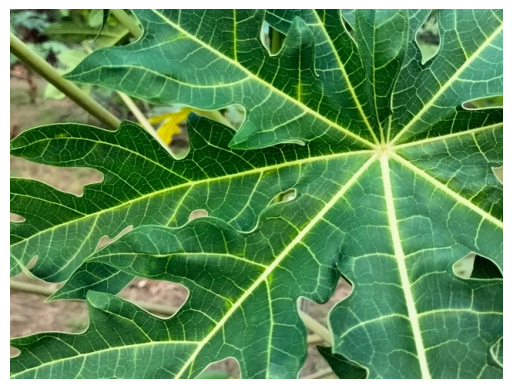

In [ ]:

from PIL import Image


# Directory containing healthy leaves images
healthy_data_set = '/content/drive/MyDrive/data_set/binary_identification/healthy'

# List all image files in the directory
image_files = [f for f in os.listdir(healthy_data_set) if f.endswith(('jpg', 'jpeg', 'png', 'bmp'))]

# Load and display the image
if image_files:
    image_path = os.path.join(healthy_data_set, image_files[50])  # Pick the first image
    image = Image.open(image_path)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No images found in the directory.")


In [ ]:
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33),
                                 interpolation=transforms.InterpolationMode.BICUBIC),  # Crop the best area
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with 50% probability
    transforms.RandomRotation(degrees=5, expand=False),  # Restrict rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),  # Minor color adjustments
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

In [ ]:
binary_dataset = datasets.ImageFolder(root=binary_data_set, transform=transform)

In [ ]:
binary_loader = DataLoader(binary_dataset, batch_size=32, shuffle=True)

In [ ]:
# Get class names for binary and disease classification
binary_classes = binary_dataset.classes


In [ ]:
print(binary_classes)

['healthy', 'unhealthy']


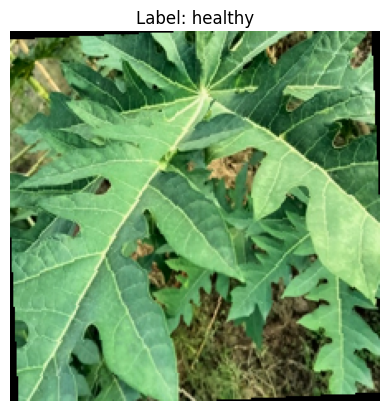

In [ ]:
# Function to unnormalize an image for visualization
def unnormalize_image(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean  # Reverse normalization

# Retrieve one sample from the dataset
image, label = binary_dataset[0]  # Index 0 corresponds to the first image in the dataset

# Unnormalize the image
unnormalized_image = unnormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Convert the image tensor to a format suitable for matplotlib (HWC and values in [0, 1])
image_to_show = unnormalized_image.permute(1, 2, 0).numpy()
image_to_show = image_to_show.clip(0, 1)  # Clip values to the range [0, 1] to handle possible overflow

# Plot the image
plt.imshow(image_to_show)
plt.title(f"Label: {binary_classes[label]}")
plt.axis("off")
plt.show()



In [ ]:
efficientnet_model = models.efficientnet_b0(pretrained=True)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 2)  # Binary output
efficientnet_model = efficientnet_model.to(device)

In [ ]:
def train_binary_model(model, dataloader, criterion, optimizer, device, num_epochs=5, save_path=None):
    model.train()

    # Create directory for saving training logs if specified
    if save_path:
        os.makedirs(save_path, exist_ok=True)

        # Generate a unique timestamp-based filename
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        csv_file = os.path.join(save_path, f"efficientnet_training_data_{timestamp}.csv")
        fieldnames = ["epoch", "loss", "accuracy"]

        # Initialize CSV with header
        with open(csv_file, mode="w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()

    # Loop over epochs
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Loop over the data
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            # Accumulate the loss
            running_loss += loss.item() * inputs.size(0)

             # Calculate accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

      # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(dataloader.dataset)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Save the epoch data to CSV
        if save_path:
            with open(csv_file, mode="a", newline="", encoding="utf-8") as file:
                writer = csv.DictWriter(file, fieldnames=fieldnames)
                writer.writerow({"epoch": epoch+1, "loss": epoch_loss, "accuracy": accuracy})

    # Return the trained model
    return model

In [ ]:
# Binary classification training setup
binary_criterion = nn.CrossEntropyLoss()
binary_optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)


In [ ]:

# Directory where the CSV file will be saved
save_directory = "/content/drive/MyDrive/training_records"



In [ ]:
# Train EfficientNet for binary classification
efficientnet_model = train_binary_model(
    efficientnet_model,
    binary_loader,
    binary_criterion,
    binary_optimizer,
    device,
    num_epochs=14,
    save_path=save_directory
)

Epoch [1/14], Loss: 0.2431, Accuracy: 89.49%
Epoch [2/14], Loss: 0.0775, Accuracy: 97.11%
Epoch [3/14], Loss: 0.0543, Accuracy: 98.42%
Epoch [4/14], Loss: 0.0462, Accuracy: 98.55%
Epoch [5/14], Loss: 0.0425, Accuracy: 98.16%
Epoch [6/14], Loss: 0.0196, Accuracy: 99.21%
Epoch [7/14], Loss: 0.0239, Accuracy: 99.21%
Epoch [8/14], Loss: 0.0389, Accuracy: 98.82%
Epoch [9/14], Loss: 0.0131, Accuracy: 99.74%
Epoch [10/14], Loss: 0.0350, Accuracy: 98.55%
Epoch [11/14], Loss: 0.0543, Accuracy: 98.42%
Epoch [12/14], Loss: 0.0116, Accuracy: 99.61%
Epoch [13/14], Loss: 0.0049, Accuracy: 100.00%
Epoch [14/14], Loss: 0.0199, Accuracy: 99.34%


In [ ]:
# Save the entire model
def save_entire_model(model, save_path, epoch=None):
    # Create the save path if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    # Define the model save file
    model_save_path = os.path.join(save_path, f"efficientnet_model_full_{timestamp}.pth")

    # Save the entire model (not recommended but works)
    torch.save(model, model_save_path)
    print(f"Entire model saved at {model_save_path}")


In [ ]:
efficiantnet_model_path = '/content/drive/MyDrive/models'

In [ ]:
# Save the entire model
save_entire_model(efficientnet_model, efficiantnet_model_path)


In [ ]:
# Loading the entire model
def load_entire_model(model_path):
    model = torch.load(model_path)
    model.eval()
    print(f"Entire model loaded from {model_path}")
    return model


In [ ]:
# Load the entire model
model_path = os.path.join(efficiantnet_model_path, "efficientnet_model_full.pth")
efficientnet_model = load_entire_model(model_path)


<ipython-input-1-e7238867e821>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Entire model loaded from /content/drive/MyDrive/models/efficientnet_model_full.pth


In [ ]:
def get_model_prediction(model, image_path, transform, device, class_labels):
    # Load and display the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set the model to evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(image_tensor)

    # Get the predicted class and the confidence score
    _, predicted_class = torch.max(outputs, 1)
    prediction_confidence = torch.nn.functional.softmax(outputs, dim=1)[0, predicted_class].item()

    # Get the predicted label from class_labels
    predicted_label = class_labels[predicted_class.item()]

    # Return the results
    return predicted_label, prediction_confidence, predicted_class.item()


In [ ]:
test_image = '/content/drive/MyDrive/effientnet_test_data/healthy/Healthy(98).jpg'

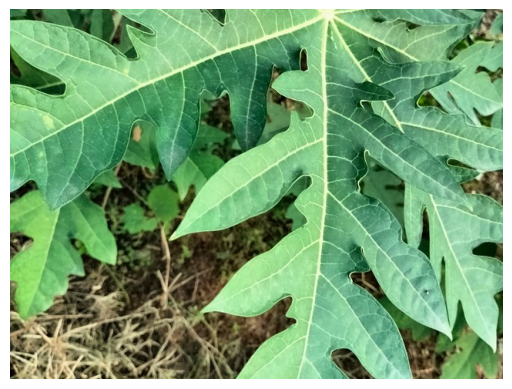

Predicted Class: Healthy
Prediction Confidence: 0.8929


In [ ]:
# Example usage
class_labels = ['Healthy', 'Unhealthy']  # Replace with actual class labels
image_transform = transform  # Use the transformation you've defined for preprocessing
predicted_label, prediction_confidence, predicted_class = get_model_prediction(
    efficientnet_model, test_image, image_transform, device, class_labels)

print(f'Predicted Class: {predicted_label}')
print(f'Prediction Confidence: {prediction_confidence:.4f}')